# Machine Learning Exercise 8 - Anomaly Detection and Recommender Systems
Programming exercise for Andrew Ng's Machine Learning Class on Coursera written in python 3.4.

## Anomaly Detection

In this exercise, an anomaly detection algorithm was used to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.stats
from scipy.optimize import minimize
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_style('white')
%matplotlib inline

In [2]:
data1 = loadmat('./machine-learning-ex8/ex8/ex8data1.mat')
X = data1['X']
Xval = data1['Xval']
yval = data1['yval']

First, plot the 2D dataset to visualize what the algorithm is doing.

In [3]:
def plotData(data):
    plt.scatter(data[:,0], data[:,1], color='b', marker='x')
    plt.xlabel('Latency (ms)', fontsize=14)
    plt.ylabel('Throughput (mb/s)', fontsize=14)

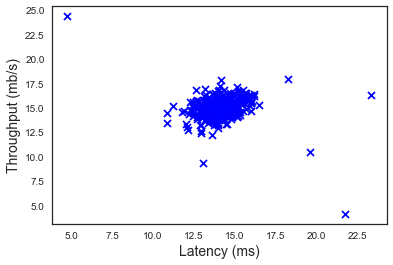

In [4]:
plotData(X)

There are a few outliers outside of the ellipse on the 2D plot. Next we will fit a Gaussian distribution of each feature and then find values that have very low probability (pdf) and hence can be considered anomalies.

### Gaussian Distribution

To perform anomaly detection, we will first need to fit a model to the data's distribution. Given a dataset, we want to estimate the Gaussian distribution for each of the features x. For each feature i = 1...n, we need to find parameters mu and sigma_squared that fit the data in the i-th dimension.

In [5]:
def estimateGaussian(data):
    """outputs the mean and variance"""
    mu = data.mean(axis=0)
    sigma2 = data.var(axis=0)
    return mu, sigma2

In [6]:
def getP(data, avg, var):
    """computes pdf for normally distributed features."""
    return np.exp(-(data-avg)**2/(2*var)) / np.sqrt(2*np.pi*var)

Next we construct data points for a contour plot visualizing the contours of the fitted Gaussian distribution.

In [7]:
mu, sigma = estimateGaussian(X)
xx, yy = np.meshgrid(np.linspace(0, 30, 200), np.linspace(0, 30, 200))

Z = (getP(xx.ravel(),mu[0],sigma[0])*getP(yy.ravel(),mu[1],sigma[1])).reshape(xx.shape)

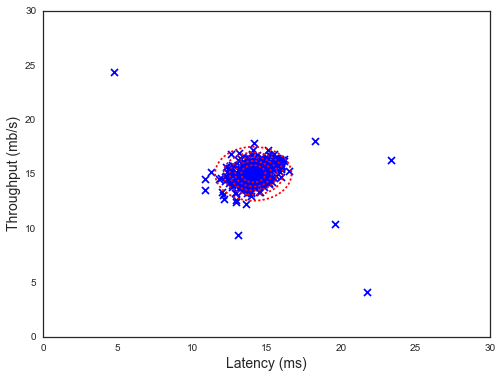

In [8]:
plt.subplots(figsize=(8, 6))
plotData(X)
plt.contour(xx, yy, Z, colors='r', linestyles='dotted')

To check if each feature satisifies the Gaussion distribution condition, we plot the histograms for each feature.

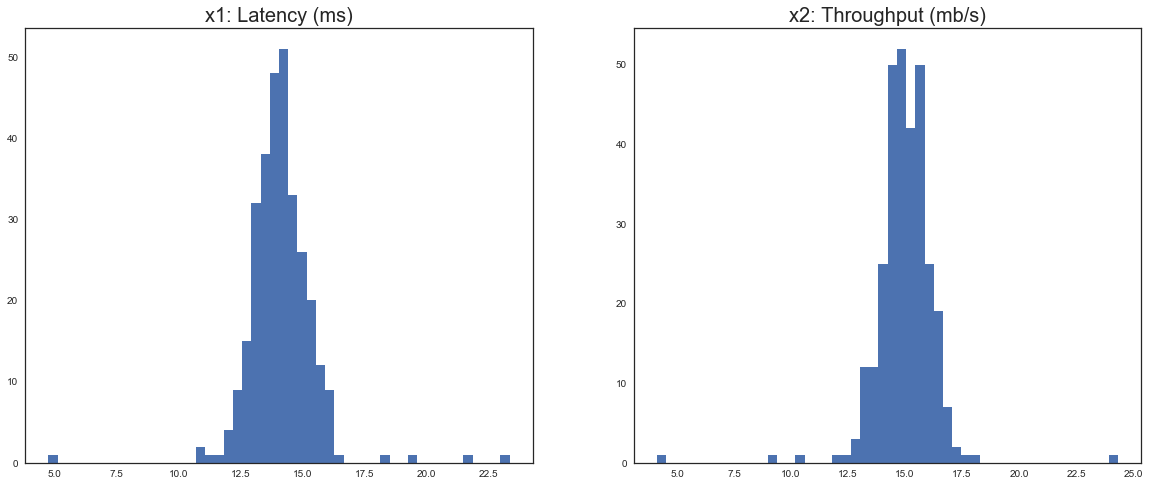

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.hist(X[:,0], bins=50)
ax1.set_title('x1: Latency (ms)', fontsize=20)
ax2.hist(X[:,1], bins=50)
ax2.set_title('x2: Throughput (mb/s)', fontsize=20)
plt.show()

The distributions of both features are quite normal. We then compute the probability distrubition function for each feature.

In [10]:
def computepdf(data, avg, var):
    p = np.zeros(data.shape)
    for i in range(p.shape[1]):
        p[:,i] = scipy.stats.norm(avg[i],var[i]).pdf(data[:,i])
    return p

In [11]:
p = computepdf(X, mu, sigma)
p = p[:,0] * p[:,1]

In [12]:
pv = computepdf(Xval, mu, sigma)
pval = pv[:,0] * pv[:,1]

### Selecting the Threshold

Now we can investigage which examples have a very high probability (normals) given this distribution and which examples have a very low probabiity (anomalies). 

In this part of the exercise, we will implement an algorighm to select the threshold epsilon using the F1 score on a cross validation set.

In [13]:
def selectThreshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    yval = yval.ravel()
    
    for epsilon in np.linspace(pval.min(), pval.max(), 1000):
        predict = pval < epsilon
        tp = np.sum((predict == 1) & (yval == 1))
        fp = np.sum((predict == 1) & (yval == 0))
        fn = np.sum((predict == 0) & (yval == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        f1 = 2*prec*rec / (prec + rec)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
            
    return best_epsilon, best_f1

In [14]:
epsilon, f1 = selectThreshold(pval, yval)
print('Best epsilon = ', epsilon)
print('Best F1 = ', f1)

Best epsilon =  0.000457595003915
Best F1 =  0.875


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in long_scalars


After finding the threshold, now we can identify the outliers on the plot.

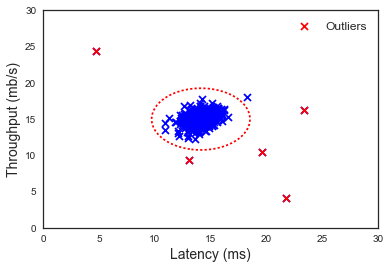

In [15]:
outliers = X[p < epsilon, :]

plotData(X)
plt.contour(xx, yy, Z, levels = [epsilon], colors='r', linestyles='dotted')
plt.scatter(outliers[:,0], outliers[:,1], color='r', marker='x', label='Outliers')
plt.legend(loc='best', fontsize=12)

In [16]:
print('Number of outliers: {}'.format(outliers.shape[0]))

Number of outliers: 5


### High Dimensional Dataset

The same algorithm can be applied to higher dimensional dataset.

In [17]:
data2 = loadmat('./machine-learning-ex8/ex8/ex8data2.mat')
X2 = data2['X']
X2val = data2['Xval']
y2val = data2['yval']

In [18]:
X2.shape

(1000, 11)

In [19]:
mu2, sigma2 = estimateGaussian(X2)

In [20]:
p = computepdf(X2, mu2, sigma2)
p2 = np.prod(p, axis=1)

p2v = computepdf(X2val, mu2, sigma2)
p2val = np.prod(p2v, axis=1)

In [21]:
epsilon, f1 = selectThreshold(p2val, y2val)
print('Best epsilon = ', epsilon)
print('Best F1 = ', f1)

Best epsilon =  7.14164780869e-25
Best F1 =  0.8


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
outliers = X2[p2 < epsilon, :]
print('Number of outliers: {}'.format(outliers.shape[0]))

Number of outliers: 55


## Recommender Systems (Collaborative Filtering)

In this part of the exerice, we will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. The dataset consists of ratings on a scale of 1 to 5.

In [23]:
data = loadmat('./machine-learning-ex8/ex8/ex8_movies.mat')
data.keys()

dict_keys(['__globals__', '__header__', '__version__', 'R', 'Y'])

In [24]:
Y = data['Y']
R = data['R']

The matrix Y (num_movies * num_users) stores the ratings, and the matrix R is a binary-valued indicator matrix with the same dimension as Y. The objective of collaborative filtering is to predict movie ratings for the movies that users haven't yet rated (i.e. entries where R(i,j)==0). This will allow us to recommend the movies with the highest predicted ratings to the users.

To calculate the average rating for each movie, we need to first mask the ones when R==0, then calculate the average of each movie with available ratings.

In [25]:
mask = np.where(R == 1)    # returns the i and j indices in tupbles
avg_rating = np.zeros(Y.shape[0])
for i in range(Y.shape[0]):
    avg_rating[i] = np.mean(Y[i, mask[1][mask[0]==i]])

Display the average rating for the first 5 movies.

In [26]:
print('Average rating for the first 5 movies: ')
for i in range(5):
    print('     Movie {}: {:>5.2f}'.format(i, avg_rating[i]))

Average rating for the first 5 movies: 
     Movie 0:  3.88
     Movie 1:  3.21
     Movie 2:  3.03
     Movie 3:  3.55
     Movie 4:  3.30


To help get an overview of the ratings, we can visualize the ratings matrix in a colored heatmap.

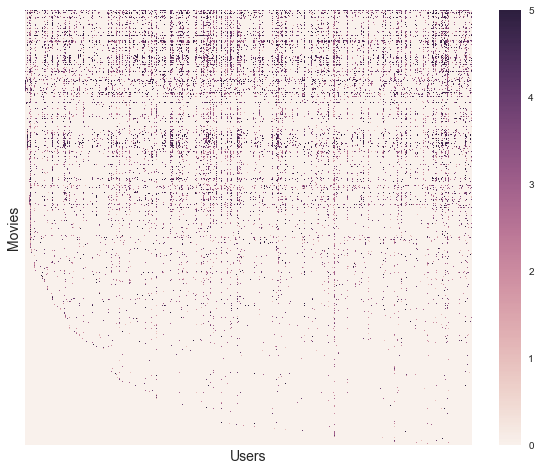

In [27]:
plt.subplots(figsize=(10, 8))
sns.heatmap(Y, xticklabels=False, yticklabels=False)
plt.xlabel('Users', fontsize=14)
plt.ylabel('Movies', fontsize=14)

### Collaborative Filtering Cost Function

In [28]:
movieParams = loadmat('./machine-learning-ex8/ex8/ex8_movieParams.mat')
X = movieParams['X']
Theta = movieParams['Theta']

Here X is a num_movies * num_features matrix and Theta is a num_users * num_features matrix.

In [29]:
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

First we check the cost function with no regularization.

In [30]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, reg=0):    
    """returns the cost and gradient for the collaborative filtering problem"""
    
    # get X and theta from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    # initialize cost and grad
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # compute cost function and gradient descent
    error  = np.dot(X, Theta.T) - Y
    squared_error = (error * R)**2
    J = 0.5 * np.sum(squared_error) + 0.5*reg*np.sum(X**2) + 0.5*reg*np.sum(Theta**2)
    X_grad = np.dot(error, Theta) + reg*X
    Theta_grad = np.dot(error.T, X) + reg*Theta
    
    grad = np.r_[X_grad.flat, Theta_grad.flat]
    
    return J, grad

In order to use the minimize function for X and Theta simultaneously, X and Theta have to be first unrolled to a single vetor parameters then reshaped back to their original dimensions in cofiCostFunc.

In [31]:
parameters = np.r_[X.ravel(), Theta.ravel()]
J, grad = cofiCostFunc(parameters, Y, R, num_users, num_movies, num_features)
print('Cost at loaded parameters: {:.2f}'.format(J))

Cost at loaded parameters: 22.22


The cost function matches with the expected. Now check the implemented gradients with the numerical answers. The analytical and numerical gradients are expected to match up closely.

In [32]:
def numerical_gradient(f, x, dx=1e-6):
    perturb = np.zeros(x.size)
    result  = np.zeros(x.size)
    for i in range(x.size):
        perturb[i] = dx
        result[i] = (f(x+perturb) - f(x-perturb)) / (2*dx)
        perturb[:] = 0
    return result

In [33]:
def check_cost_function(lambda_=0):
    X = np.random.rand(4, 3)
    Theta = np.random.rand(5, 3)
    Y = X.dot(Theta.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape).astype(bool)
    R[Y != 0] = True
    
    X = np.random.rand(4, 3)
    Theta = np.random.rand(5, 3)
    
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta.shape[1]
    
    def cost(params):
        return cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_)[0]
    
    num_grad = numerical_gradient(cost, np.r_[X.flat, Theta.flat])
    
    cost, grad = cofiCostFunc(np.r_[X.flat, Theta.flat], Y, R, num_users, num_movies, num_features, lambda_)
    print(np.c_[num_grad, grad])
    print('Average difference:', np.mean((num_grad - grad) ** 2))

In [34]:
check_cost_function()

[[ 0.02830945  1.92685956]
 [-0.05334757  3.79075102]
 [-0.18118539  3.03674129]
 [-0.67815909 -0.63008671]
 [-1.41339149 -0.85163359]
 [-0.80661192 -0.22972175]
 [ 1.08584908  1.08584908]
 [ 2.7059319   2.7059319 ]
 [ 2.3451486   2.34514859]
 [-0.1041025  -0.0255143 ]
 [-0.47223917  0.26751204]
 [-0.07034378  0.70704535]
 [-0.57047655 -0.57047655]
 [-0.37157876 -0.37157876]
 [-0.22747065 -0.22747065]
 [-0.53464128 -0.28394801]
 [-0.79706767 -0.73412287]
 [-0.16821936 -0.02903996]
 [ 0.53556221  2.40585522]
 [ 0.7765991   2.78368767]
 [ 1.19411156  2.28134461]
 [-0.26375156  0.45243237]
 [ 0.12905958  0.94430046]
 [ 0.10927967  0.51148022]
 [ 0.40456366  2.28509095]
 [ 0.98638883  2.76453277]
 [ 1.38319774  2.43551875]]
Average difference: 1.79572527784


Next we check the cost function with regularization.

In [35]:
J, grad = cofiCostFunc(parameters, Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters: {:.2f}'.format(J))

Cost at loaded parameters: 31.34


In [36]:
check_cost_function(1.5)

[[ 0.60236606  1.01738371]
 [ 0.99307598  1.46481237]
 [-0.28286909  0.0919812 ]
 [-0.238773    0.27981214]
 [-0.09176407  0.61206212]
 [ 0.96292224  1.84987963]
 [ 0.5194561   0.95875271]
 [-0.071214    0.32582702]
 [ 0.19055669  0.44696909]
 [ 1.61902107  3.09192178]
 [ 0.43875623  1.44644429]
 [-0.07723337  0.49506621]
 [-0.12078028  0.20963145]
 [ 0.297713    0.60879217]
 [ 1.05689557  1.61189881]
 [ 1.4598233   1.67548644]
 [ 0.8914729   0.93239603]
 [ 0.11473179  0.37649919]
 [ 0.99179869  2.09785726]
 [ 0.51151151  0.97523977]
 [-0.15052449  0.21473158]
 [-0.8824885  -0.68598728]
 [-0.35266783 -0.27143806]
 [ 0.5480459   0.9906489 ]
 [ 0.8727148   2.26699094]
 [ 0.87184974  1.85468979]
 [ 0.37216262  1.12035056]]
Average difference: 0.441793541457


### Entering ratings for a new user
Before we will train the collaborative filtering model, we will first add ratings that correspond to a new user that we just observed. This part of the code will also allow you to put in your own ratings for the movies in the dataset!

In [37]:
with open('./machine-learning-ex8/ex8/movie_ids.txt', encoding='latin1') as f:
    movies = [line.strip().split(' ', 1)[1] for line in f]

In [38]:
my_ratings = np.zeros(len(movies))

Provide ratings for a few movies and store them to my_ratings.

In [39]:
ratings = {1: 4, 98: 2, 7: 3, 12: 5, 54: 4, 64: 5, 66: 3, 69: 5, 183: 4, 226: 5, 355: 5}

Now display these ratings.

In [40]:
for k, v in ratings.items():
    my_ratings[k-1] = v

print('New user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('{:>40} rating: {}'.format(movies[i],my_ratings[i]))

New user ratings:

                        Toy Story (1995) rating: 4.0
                   Twelve Monkeys (1995) rating: 3.0
              Usual Suspects, The (1995) rating: 5.0
                         Outbreak (1995) rating: 4.0
        Shawshank Redemption, The (1994) rating: 5.0
          While You Were Sleeping (1995) rating: 3.0
                     Forrest Gump (1994) rating: 5.0
        Silence of the Lambs, The (1991) rating: 2.0
                            Alien (1979) rating: 4.0
                       Die Hard 2 (1990) rating: 5.0
                           Sphere (1998) rating: 5.0


### Learning Movie Ratings
Now, you will train the collaborative filtering model on a movie rating dataset of 1682 movies and 943 users.

In [41]:
data = loadmat('./machine-learning-ex8/ex8/ex8_movies.mat')
Y = data['Y']
R = data['R']

Add my own ratings to the data matrix.

In [42]:
Y = np.c_[my_ratings, Y]
R = np.c_[(my_ratings > 0).astype('int'), R]

In [43]:
def normalizeRatings(Y, R):
    mask = np.where(R == 1)    # returns the i and j indices in tupbles
    Ymean = np.zeros(Y.shape[0])
    Ynorm = np.zeros(Y.shape)
    
    for i in range(Y.shape[0]):
        Ymean[i] = np.mean(Y[i, mask[1][mask[0]==i]])
        Ynorm[i,:] = Y[i,:] - Ymean[i]
    
    return Ymean, Ynorm

In [44]:
Ymean, Ynorm = normalizeRatings(Y, R)

In [45]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
# Set Regularization
reg = 10

# Set Initial Parameters
X = np.random.rand(num_movies, num_features)
Theta = np.random.rand(num_users, num_features)

initial_params = np.r_[X.flatten(), Theta.flatten()]

Use the minimize function to optimize X and Theta with Y and R and inputs. I tried using Ynorm as input but the computation didn't seem to terminate successfully. Maybe it's because the function failed to converge with Ynorm as the input. Given the scale of Y is between 1-5, the use of Y should also be appropriate for the optimization.

In [46]:
res = minimize(cofiCostFunc, initial_params, args=(Y,R, num_users, num_movies, num_features, reg), jac=True)

In [47]:
res

      fun: 185023.57450386061
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([  491.35896313,   481.68580519,   537.60148386, ...,  1724.72368663,
        1686.59839422,  1616.64140473])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 111
      nit: 0
     njev: 99
   status: 2
  success: False
        x: array([ 0.47758348,  0.53531957,  0.83878488, ...,  0.91341268,
        0.75277007,  0.08492411])

### Unfold the returned theta back into U and W

In [48]:
X = res.x[:num_movies*num_features].reshape(num_movies, num_features)
Theta = res.x[num_movies*num_features:].reshape(num_users, num_features)

With the optimized X and Theta from the previous part, we can compute the predited ratings below. The codes below add ratings only to the movies that the users have not yet watched.

In [49]:
pred = np.zeros_like(Y)

for i, j in zip(*mask):
    pred[i, j] = np.dot(X[i,:], Theta[j,:].T)

In [50]:
idx = pred[:,0].argsort()[-10:][::-1]

print('Top recommendations for you:\n')
for i in idx:
    if R[i,0] == 0:
        print('Predicting rating {:.1f} for movie {}'.format(pred[i,0], movies[i]))
    else:
        continue

Top recommendations for you:

Predicting rating 4.1 for movie Terminator, The (1984)
Predicting rating 4.1 for movie Nikita (La Femme Nikita) (1990)
Predicting rating 4.1 for movie Swingers (1996)
Predicting rating 4.1 for movie When the Cats Away (Chacun cherche son chat) (1996)
Predicting rating 4.1 for movie White Balloon, The (1995)
Predicting rating 4.0 for movie Billy Madison (1995)
Predicting rating 3.9 for movie French Twist (Gazon maudit) (1995)
Predicting rating 3.9 for movie Much Ado About Nothing (1993)
Predicting rating 3.8 for movie D3: The Mighty Ducks (1996)
Predicting rating 3.8 for movie Devil's Own, The (1997)


In [51]:
print('Original ratings provided:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i], movies[i]))

Original ratings provided:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)
